In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
if params.feat_sel == 'auto': # automatic feature selection, based on feature importance notebook
    
    df_feat_sel = pd.read_csv(params.feat_sel_auto_csv, index_col=0, parse_dates=True)
    
elif params.feat_sel == 'man': # alternative manual feature selection, based on the features selected in the params.py
    
    df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_15,rsi,stoch_k_14,eng_ma,bid,ask,signal
2004-01-02 13:07:00,-0.996380,-0.987015,-1.005076,-0.943230,-0.009476,-2.476841,-1.552562,-0.001209,0.763698,0.764840,0.069210
2004-01-02 13:08:00,-0.994579,-0.986828,-1.001603,-0.937271,-0.017401,-2.476841,-1.552562,-0.001209,0.763681,0.764824,0.073291
2004-01-02 13:09:00,-0.992906,-0.986557,-0.999187,-0.930276,-0.025327,-2.476841,-1.552562,-0.001209,0.763664,0.764807,0.077619
2004-01-02 13:10:00,-0.991353,-0.986209,-0.997370,-0.922523,-0.033253,-2.476841,-1.552562,-0.001209,0.763647,0.764790,0.082208
2004-01-02 13:11:00,-0.989911,-0.985789,-0.995973,-0.914218,-0.041178,-2.476841,-1.552562,-0.001209,0.763631,0.764773,0.087074
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.582507,0.182057,0.348747,0.119570,1.315228,0.811095,0.354296,12.115664,196.667400,196.962600,0.417935
2025-06-18 20:57:00,0.641713,0.207647,0.391507,0.184714,1.113128,0.539711,0.426843,12.401440,196.527500,196.822500,0.368513
2025-06-18 20:58:00,0.574130,0.230765,0.392142,0.238300,0.827243,0.530165,0.381683,12.401440,196.522500,196.817500,0.365417
2025-06-18 20:59:00,0.695123,0.261866,0.692251,0.242399,-0.093724,-0.151391,-0.182061,9.257911,196.092800,196.387200,0.280949


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2414427, 60, 8]) (samples, look_back, features)
  y_sig     = torch.Size([2414427]) (samples,)
  y_ret     = torch.Size([2414427]) (samples,)
  raw_close = torch.Size([2414427])
  raw_bid   = torch.Size([2414427])
  raw_ask   = torch.Size([2414427])
  end_times = (2414427,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1696435, 60, 8])
  y_sig_tr, y_ret_tr = torch.Size([1696435]) torch.Size([1696435])
  X_val = torch.Size([353133, 60, 8])
  y_sig_val, y_ret_val = torch.Size([353133]) torch.Size([353133])
  X_te  = torch.Size([364859, 60, 8])
  y_sig_te, y_ret_te = torch.Size([364859]) torch.Size([364859])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(8, 24, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(48, 32, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
  (cls_head): Linear(in_features=64, out_features=1, bias=True)
  (cls_ter): Linear(in_features=64, out_features=3, bias=True)
)

In [8]:
# # -----------------------------------------------------------------------------
# # Compute plateau_sched timing parameters
# # -----------------------------------------------------------------------------
# # Total training samples = total windows in X_tr (one window per row)
# n_train_samples = X_tr.shape[0]

# # How many optimizer steps (day‐bundles) constitute one epoch?
# steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.422203,  val = 0.414883

Train target stats:
  mean = 0.3101,  var = 0.0821,  std = 0.2865
Train mean‐predictor baseline:
  RMSE_baseline = 0.286539
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.3102,  var = 0.0759,  std = 0.2755
Validation mean‐predictor baseline:
  RMSE_baseline = 0.275513
  R²_baseline   = 0.00



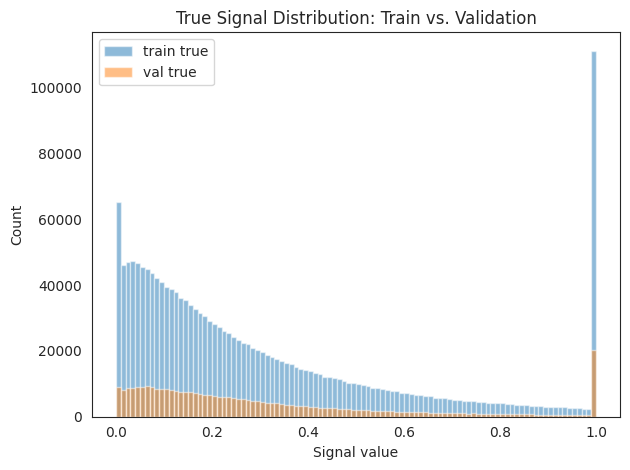

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3808 unique trading days per epoch.



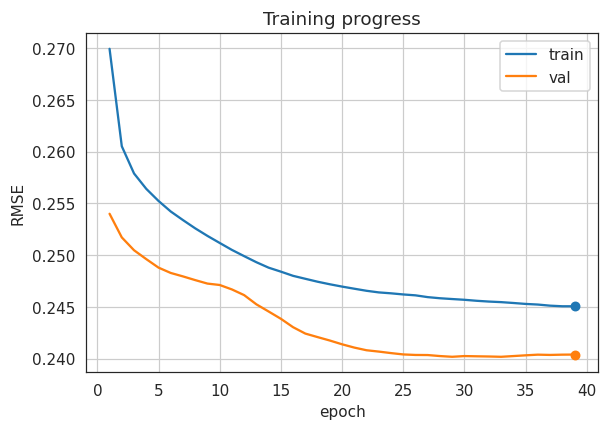

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2699 MAE=0.2127 R2=0.1115 | "B": Acc=0.6966 Prec=0.3171 Rec=0.1994 F1=0.2449 AUROC=0.5394
VALID→ "R": RMSE=0.2540 MAE=0.1865 R2=0.1501 | "B": Acc=0.6979 Prec=0.3591 Rec=0.3497 F1=0.3544 AUROC=0.6004


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2605 MAE=0.2033 R2=0.1724 | "B": Acc=0.6589 Prec=0.3026 Rec=0.2934 F1=0.2979 AUROC=0.5520
VALID→ "R": RMSE=0.2517 MAE=0.1847 R2=0.1654 | "B": Acc=0.6807 Prec=0.3580 Rec=0.4373 F1=0.3937 AUROC=0.6294


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2579 MAE=0.2013 R2=0.1890 | "B": Acc=0.6396 Prec=0.3080 Rec=0.3698 F1=0.3361 AUROC=0.5705
VALID→ "R": RMSE=0.2505 MAE=0.1834 R2=0.1736 | "B": Acc=0.6724 Prec=0.3579 Rec=0.4808 F1=0.4103 AUROC=0.6439


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2564 MAE=0.2001 R2=0.1984 | "B": Acc=0.6322 Prec=0.3104 Rec=0.4022 F1=0.3504 AUROC=0.5786
VALID→ "R": RMSE=0.2496 MAE=0.1824 R2=0.1792 | "B": Acc=0.6620 Prec=0.3559 Rec=0.5253 F1=0.4243 AUROC=0.6512


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2552 MAE=0.1991 R2=0.2057 | "B": Acc=0.6342 Prec=0.3170 Rec=0.4184 F1=0.3607 AUROC=0.5877
VALID→ "R": RMSE=0.2488 MAE=0.1814 R2=0.1846 | "B": Acc=0.6633 Prec=0.3587 Rec=0.5333 F1=0.4289 AUROC=0.6556


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2542 MAE=0.1982 R2=0.2120 | "B": Acc=0.6353 Prec=0.3194 Rec=0.4234 F1=0.3641 AUROC=0.5909
VALID→ "R": RMSE=0.2483 MAE=0.1804 R2=0.1880 | "B": Acc=0.6583 Prec=0.3558 Rec=0.5441 F1=0.4302 AUROC=0.6549


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2534 MAE=0.1974 R2=0.2171 | "B": Acc=0.6390 Prec=0.3218 Rec=0.4185 F1=0.3638 AUROC=0.5933
VALID→ "R": RMSE=0.2479 MAE=0.1795 R2=0.1902 | "B": Acc=0.6562 Prec=0.3533 Rec=0.5420 F1=0.4278 AUROC=0.6514


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2526 MAE=0.1967 R2=0.2221 | "B": Acc=0.6422 Prec=0.3236 Rec=0.4132 F1=0.3630 AUROC=0.5933
VALID→ "R": RMSE=0.2476 MAE=0.1787 R2=0.1925 | "B": Acc=0.6506 Prec=0.3487 Rec=0.5458 F1=0.4255 AUROC=0.6473


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2519 MAE=0.1961 R2=0.2265 | "B": Acc=0.6373 Prec=0.3208 Rec=0.4210 F1=0.3641 AUROC=0.5918
VALID→ "R": RMSE=0.2472 MAE=0.1780 R2=0.1947 | "B": Acc=0.6526 Prec=0.3483 Rec=0.5339 F1=0.4216 AUROC=0.6449


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2512 MAE=0.1955 R2=0.2307 | "B": Acc=0.6344 Prec=0.3171 Rec=0.4181 F1=0.3607 AUROC=0.5884
VALID→ "R": RMSE=0.2471 MAE=0.1775 R2=0.1956 | "B": Acc=0.6633 Prec=0.3503 Rec=0.4916 F1=0.4091 AUROC=0.6439


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2505 MAE=0.1949 R2=0.2348 | "B": Acc=0.6394 Prec=0.3199 Rec=0.4104 F1=0.3596 AUROC=0.5896
VALID→ "R": RMSE=0.2467 MAE=0.1770 R2=0.1984 | "B": Acc=0.6585 Prec=0.3426 Rec=0.4791 F1=0.3995 AUROC=0.6393


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2499 MAE=0.1944 R2=0.2385 | "B": Acc=0.6322 Prec=0.3133 Rec=0.4123 F1=0.3561 AUROC=0.5830
VALID→ "R": RMSE=0.2461 MAE=0.1765 R2=0.2019 | "B": Acc=0.6596 Prec=0.3377 Rec=0.4533 F1=0.3870 AUROC=0.6336


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2493 MAE=0.1938 R2=0.2421 | "B": Acc=0.6295 Prec=0.3094 Rec=0.4073 F1=0.3516 AUROC=0.5792
VALID→ "R": RMSE=0.2452 MAE=0.1760 R2=0.2077 | "B": Acc=0.6578 Prec=0.3356 Rec=0.4527 F1=0.3855 AUROC=0.6324


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2488 MAE=0.1933 R2=0.2453 | "B": Acc=0.6273 Prec=0.3082 Rec=0.4106 F1=0.3521 AUROC=0.5778
VALID→ "R": RMSE=0.2445 MAE=0.1757 R2=0.2122 | "B": Acc=0.6578 Prec=0.3377 Rec=0.4613 F1=0.3900 AUROC=0.6352


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2484 MAE=0.1929 R2=0.2476 | "B": Acc=0.6246 Prec=0.3078 Rec=0.4178 F1=0.3544 AUROC=0.5780
VALID→ "R": RMSE=0.2438 MAE=0.1755 R2=0.2167 | "B": Acc=0.6488 Prec=0.3356 Rec=0.4910 F1=0.3987 AUROC=0.6379


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2480 MAE=0.1926 R2=0.2501 | "B": Acc=0.6239 Prec=0.3088 Rec=0.4239 F1=0.3573 AUROC=0.5806
VALID→ "R": RMSE=0.2430 MAE=0.1753 R2=0.2219 | "B": Acc=0.6595 Prec=0.3439 Rec=0.4803 F1=0.4008 AUROC=0.6448


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2477 MAE=0.1923 R2=0.2518 | "B": Acc=0.6299 Prec=0.3129 Rec=0.4182 F1=0.3579 AUROC=0.5844
VALID→ "R": RMSE=0.2424 MAE=0.1752 R2=0.2259 | "B": Acc=0.6572 Prec=0.3461 Rec=0.5016 F1=0.4096 AUROC=0.6498


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2474 MAE=0.1920 R2=0.2535 | "B": Acc=0.6216 Prec=0.3105 Rec=0.4374 F1=0.3632 AUROC=0.5845
VALID→ "R": RMSE=0.2421 MAE=0.1752 R2=0.2280 | "B": Acc=0.6518 Prec=0.3464 Rec=0.5288 F1=0.4186 AUROC=0.6531


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2472 MAE=0.1917 R2=0.2550 | "B": Acc=0.6244 Prec=0.3129 Rec=0.4373 F1=0.3648 AUROC=0.5871
VALID→ "R": RMSE=0.2417 MAE=0.1752 R2=0.2301 | "B": Acc=0.6557 Prec=0.3496 Rec=0.5254 F1=0.4198 AUROC=0.6556


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2470 MAE=0.1915 R2=0.2563 | "B": Acc=0.6272 Prec=0.3167 Rec=0.4420 F1=0.3690 AUROC=0.5912
VALID→ "R": RMSE=0.2414 MAE=0.1752 R2=0.2324 | "B": Acc=0.6637 Prec=0.3590 Rec=0.5328 F1=0.4290 AUROC=0.6643


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2467 MAE=0.1913 R2=0.2576 | "B": Acc=0.6316 Prec=0.3209 Rec=0.4422 F1=0.3719 AUROC=0.5954
VALID→ "R": RMSE=0.2411 MAE=0.1753 R2=0.2345 | "B": Acc=0.6602 Prec=0.3589 Rec=0.5508 F1=0.4346 AUROC=0.6672


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2465 MAE=0.1911 R2=0.2588 | "B": Acc=0.6330 Prec=0.3238 Rec=0.4486 F1=0.3761 AUROC=0.5996
VALID→ "R": RMSE=0.2408 MAE=0.1754 R2=0.2361 | "B": Acc=0.6655 Prec=0.3640 Rec=0.5497 F1=0.4380 AUROC=0.6707


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2464 MAE=0.1909 R2=0.2597 | "B": Acc=0.6338 Prec=0.3245 Rec=0.4480 F1=0.3764 AUROC=0.5993
VALID→ "R": RMSE=0.2407 MAE=0.1755 R2=0.2369 | "B": Acc=0.6614 Prec=0.3626 Rec=0.5653 F1=0.4418 AUROC=0.6722


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2463 MAE=0.1909 R2=0.2602 | "B": Acc=0.6354 Prec=0.3280 Rec=0.4562 F1=0.3816 AUROC=0.6045
VALID→ "R": RMSE=0.2405 MAE=0.1756 R2=0.2378 | "B": Acc=0.6586 Prec=0.3626 Rec=0.5807 F1=0.4464 AUROC=0.6756


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2462 MAE=0.1907 R2=0.2609 | "B": Acc=0.6373 Prec=0.3308 Rec=0.4598 F1=0.3848 AUROC=0.6081
VALID→ "R": RMSE=0.2404 MAE=0.1757 R2=0.2387 | "B": Acc=0.6614 Prec=0.3647 Rec=0.5765 F1=0.4467 AUROC=0.6767


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2461 MAE=0.1907 R2=0.2614 | "B": Acc=0.6361 Prec=0.3301 Rec=0.4616 F1=0.3849 AUROC=0.6071
VALID→ "R": RMSE=0.2403 MAE=0.1758 R2=0.2390 | "B": Acc=0.6590 Prec=0.3645 Rec=0.5896 F1=0.4505 AUROC=0.6793


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2459 MAE=0.1905 R2=0.2625 | "B": Acc=0.6413 Prec=0.3345 Rec=0.4594 F1=0.3872 AUROC=0.6123
VALID→ "R": RMSE=0.2403 MAE=0.1760 R2=0.2390 | "B": Acc=0.6611 Prec=0.3659 Rec=0.5862 F1=0.4506 AUROC=0.6798


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2458 MAE=0.1904 R2=0.2631 | "B": Acc=0.6379 Prec=0.3315 Rec=0.4606 F1=0.3855 AUROC=0.6091
VALID→ "R": RMSE=0.2402 MAE=0.1761 R2=0.2397 | "B": Acc=0.6586 Prec=0.3647 Rec=0.5928 F1=0.4516 AUROC=0.6805


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2457 MAE=0.1903 R2=0.2636 | "B": Acc=0.6404 Prec=0.3357 Rec=0.4681 F1=0.3910 AUROC=0.6146
VALID→ "R": RMSE=0.2402 MAE=0.1763 R2=0.2401 | "B": Acc=0.6585 Prec=0.3664 Rec=0.6041 F1=0.4561 AUROC=0.6842


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2457 MAE=0.1903 R2=0.2640 | "B": Acc=0.6381 Prec=0.3348 Rec=0.4736 F1=0.3923 AUROC=0.6149
VALID→ "R": RMSE=0.2402 MAE=0.1763 R2=0.2397 | "B": Acc=0.6559 Prec=0.3647 Rec=0.6084 F1=0.4560 AUROC=0.6841


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2456 MAE=0.1902 R2=0.2646 | "B": Acc=0.6369 Prec=0.3348 Rec=0.4785 F1=0.3940 AUROC=0.6164
VALID→ "R": RMSE=0.2402 MAE=0.1764 R2=0.2398 | "B": Acc=0.6569 Prec=0.3666 Rec=0.6142 F1=0.4591 AUROC=0.6862


Epoch 32:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2455 MAE=0.1900 R2=0.2650 | "B": Acc=0.6417 Prec=0.3381 Rec=0.4727 F1=0.3942 AUROC=0.6183
VALID→ "R": RMSE=0.2402 MAE=0.1766 R2=0.2399 | "B": Acc=0.6618 Prec=0.3706 Rec=0.6108 F1=0.4613 AUROC=0.6890


Epoch 33:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2455 MAE=0.1901 R2=0.2654 | "B": Acc=0.6441 Prec=0.3393 Rec=0.4675 F1=0.3932 AUROC=0.6186
VALID→ "R": RMSE=0.2402 MAE=0.1766 R2=0.2401 | "B": Acc=0.6605 Prec=0.3692 Rec=0.6092 F1=0.4598 AUROC=0.6877


Epoch 34:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2454 MAE=0.1899 R2=0.2659 | "B": Acc=0.6443 Prec=0.3397 Rec=0.4683 F1=0.3937 AUROC=0.6189
VALID→ "R": RMSE=0.2402 MAE=0.1767 R2=0.2397 | "B": Acc=0.6605 Prec=0.3693 Rec=0.6106 F1=0.4603 AUROC=0.6883


Epoch 35:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2453 MAE=0.1899 R2=0.2664 | "B": Acc=0.6448 Prec=0.3404 Rec=0.4694 F1=0.3946 AUROC=0.6198
VALID→ "R": RMSE=0.2403 MAE=0.1767 R2=0.2392 | "B": Acc=0.6621 Prec=0.3719 Rec=0.6174 F1=0.4642 AUROC=0.6922


Epoch 36:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2452 MAE=0.1898 R2=0.2668 | "B": Acc=0.6461 Prec=0.3429 Rec=0.4748 F1=0.3982 AUROC=0.6232
VALID→ "R": RMSE=0.2404 MAE=0.1767 R2=0.2388 | "B": Acc=0.6563 Prec=0.3680 Rec=0.6269 F1=0.4638 AUROC=0.6915


Epoch 37:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2451 MAE=0.1897 R2=0.2674 | "B": Acc=0.6411 Prec=0.3392 Rec=0.4804 F1=0.3977 AUROC=0.6215
VALID→ "R": RMSE=0.2403 MAE=0.1768 R2=0.2390 | "B": Acc=0.6512 Prec=0.3642 Rec=0.6318 F1=0.4620 AUROC=0.6903


Epoch 38:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2451 MAE=0.1896 R2=0.2677 | "B": Acc=0.6426 Prec=0.3400 Rec=0.4772 F1=0.3971 AUROC=0.6221
VALID→ "R": RMSE=0.2404 MAE=0.1768 R2=0.2388 | "B": Acc=0.6596 Prec=0.3706 Rec=0.6241 F1=0.4651 AUROC=0.6934


Epoch 39:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2451 MAE=0.1896 R2=0.2677 | "B": Acc=0.6475 Prec=0.3450 Rec=0.4778 F1=0.4007 AUROC=0.6267
VALID→ "R": RMSE=0.2404 MAE=0.1769 R2=0.2387 | "B": Acc=0.6558 Prec=0.3687 Rec=0.6343 F1=0.4664 AUROC=0.6942
Early stopping at epoch 39

Champion validation RMSE = 0.240170
Improvement over zero‐baseline =  42.1%
Improvement over mean‐baseline =  12.8%


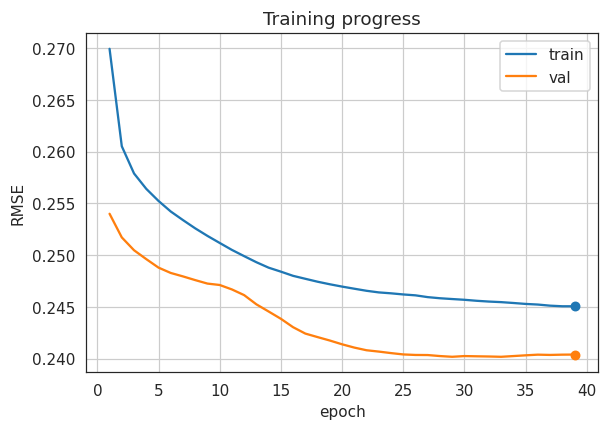

In [11]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

